By [Kevin Michalewicz](https://kevinmichalewicz.com), [Martin Millon](https://martin-millon.gitlab.io/) and Fred Dux on January 2023

This notebook details how to jointly deconvolve four images of a lensed quasar using STARRED. In most cases, the extended sources can be reconstructed on pixelated grid regularised with wavelet but here we also demonstrate the capability of STARRED to fit analytical profile for representing the extended source (e.g. a Sersic Profile). 


In [1]:
import glob
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import os
from pprint import pprint


from time import time
t0 = time()


from copy import deepcopy
from matplotlib import colors

from starred.deconvolution.deconvolution import Deconv, setup_model
from starred.deconvolution.loss import Loss, Prior
from starred.optim.optimization import Optimizer
from starred.utils.noise_utils import propagate_noise
from starred.deconvolution.parameters import ParametersDeconv
from starred.plots.plot_function import view_deconv_model, plot_loss, plot_deconvolution
from starred.procedures.deconvolution_routines import multi_steps_deconvolution

# Loading data, defining parameters

In [2]:
# hyperparameters of regularization:
lambda_scales = 1.0 # this should be ~ 1, but you can adjust it.
lambda_hf = 5.0 
subsampling_factor = 2 # the upsampling we used to represent the PSF

data_path = 'data/3_observations'
psf_path = 'data/3_psfs'


In [3]:
# Retrieving data
file_paths = sorted(glob.glob(os.path.join(data_path, '*.npy')))
data = np.array([np.load(f) for f in file_paths])
# data: one image per epoch. shape: (epochs, npix, npix)
epochs = data.shape[0]
im_size = data.shape[1]

print(data.shape)

(4, 32, 32)


In [4]:
# Retrieving the PSF 
file_paths = sorted(glob.glob(os.path.join(psf_path, '*.npy')))
s = np.array([np.load(f) for f in file_paths])
im_size_up = s.shape[1]

print(s.shape)

(4, 64, 64)


Let's see what the data looks like.

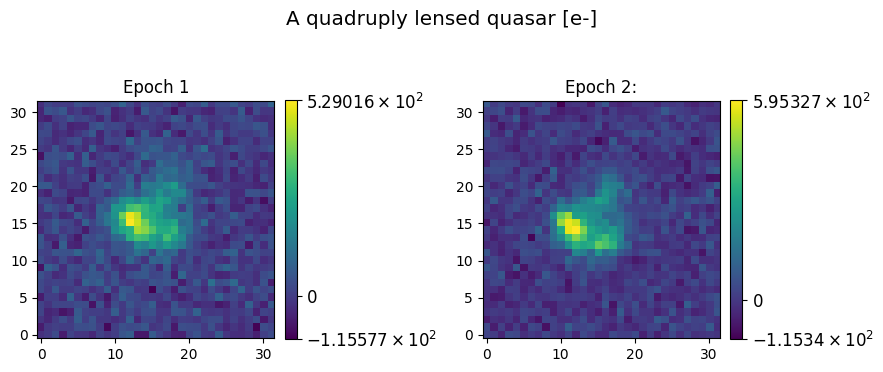

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(9,4))
fraction = 0.046
pad = 0.04

plt.rc('font', size=12)           
axs[0].set_title('Epoch 1', fontsize=12)
axs[0].tick_params(axis='both', which='major', labelsize=10)
axs[1].set_title('Epoch 2:', fontsize=12)
axs[1].tick_params(axis='both', which='major', labelsize=10)
plt.suptitle('A quadruply lensed quasar [e-]')
fig.colorbar(axs[0].imshow(data[0,:,:], norm=colors.SymLogNorm(linthresh=1e3), origin='lower'), 
             ax=axs[0], fraction=fraction, pad=pad)
fig.colorbar(axs[1].imshow(data[1,:,:], norm=colors.SymLogNorm(linthresh=1e3), origin='lower'), 
             ax=axs[1], fraction=fraction, pad=pad)
plt.tight_layout()
plt.show()

In [6]:
# Noise map
sigma_2 = np.zeros((epochs, im_size, im_size))
sigma_sky_2 = np.array([np.std(data[i,int(0.9*im_size):,int(0.9*im_size):]) for i in range(epochs)]) ** 2

for i in range(epochs):
    sigma_2[i,:,:] = sigma_sky_2[i] + data[i,:,:].clip(min=0)

#normalise:
norm = data[0].max() / 100.
data /= norm
sigma_2 /= norm**2 

In [7]:
# Parameter initialization

# positions of the point sources.
# they are given starting from the center
# of the image, in pixels.
# we can measure them from the plot above.
# (matplotlib gives us the coordinates upon hovering)
# then we subtract half the size of the image to center them.
offset = (im_size-1)/2.
initial_c_x = np.array([12.28, 13.62, 17.13, 17.6]) - offset
initial_c_y = np.array([15.53, 14.27, 12.73, 20.1]) - offset

# we give the inital amplitude for one epoch. The setup function
# replicates them for all epochs. You can fine tune this later
# if you feel like your amplitudes are widely different on an
# epoch-per-epoch basis.
pts_amp = np.asarray([5500, 5000, 5000, 3000]) / norm
initial_a = [pts_amp[j]  for i in range(epochs) for j in range(len(pts_amp))]

# the setup function gives us a model class, with
# dictionaries of parameters.
model, kwargs_init, kwargs_up, kwargs_down, kwargs_fixed = setup_model(data, 
                                                                       sigma_2, 
                                                                       s, 
                                                                       initial_c_x,
                                                                       initial_c_y,
                                                                       subsampling_factor,
                                                                       initial_a = initial_a,
                                                                       N_sersic = 1)

#let's rise a bit the Sersic parameters, index 0 refers to the first sersic: 
kwargs_init['kwargs_sersic']['amp'][0] = 10./norm
kwargs_init['kwargs_sersic']['e1'][0] = -0.1
kwargs_init['kwargs_sersic']['e2'][0] = -0.1
kwargs_init['kwargs_sersic']['center_x'][0] = 0.5
kwargs_init['kwargs_sersic']['center_y'][0] = 1.0

# we can modify them if we want to.
# for example, let's shift the second epoch slightly
# to match our data better:
kwargs_init['kwargs_analytic']['dx'][1] = -1.1 
kwargs_init['kwargs_analytic']['dy'][1] = -0.7 

parameters = ParametersDeconv(kwargs_init, 
                              kwargs_fixed, 
                              kwargs_up=kwargs_up, 
                              kwargs_down=kwargs_down)

# print our initial parameters:
print(kwargs_init)

{'kwargs_analytic': {'c_x': array([-3.22, -1.88,  1.63,  2.1 ]), 'c_y': array([ 0.03, -1.23, -2.77,  4.6 ]), 'dx': array([ 0. , -1.1,  0. ,  0. ]), 'dy': array([ 0. , -0.7,  0. ,  0. ]), 'alpha': array([0., 0., 0., 0.]), 'a': array([8.90065272, 8.09150248, 8.09150248, 4.85490149, 8.90065272,
       8.09150248, 8.09150248, 4.85490149, 8.90065272, 8.09150248,
       8.09150248, 4.85490149, 8.90065272, 8.09150248, 8.09150248,
       4.85490149])}, 'kwargs_background': {'h': array([0., 0., 0., ..., 0., 0., 0.]), 'mean': array([0., 0., 0., 0.])}, 'kwargs_sersic': {'amp': [1.8903012643975512], 'R_sersic': [1.0], 'n_sersic': [1.0], 'center_x': [0.5], 'center_y': [1.0], 'e1': [-0.1], 'e2': [-0.1]}}


************************************************************************************************


Now we can check whether our initial guess is good, and iterate back to the previous cell if it isn't.

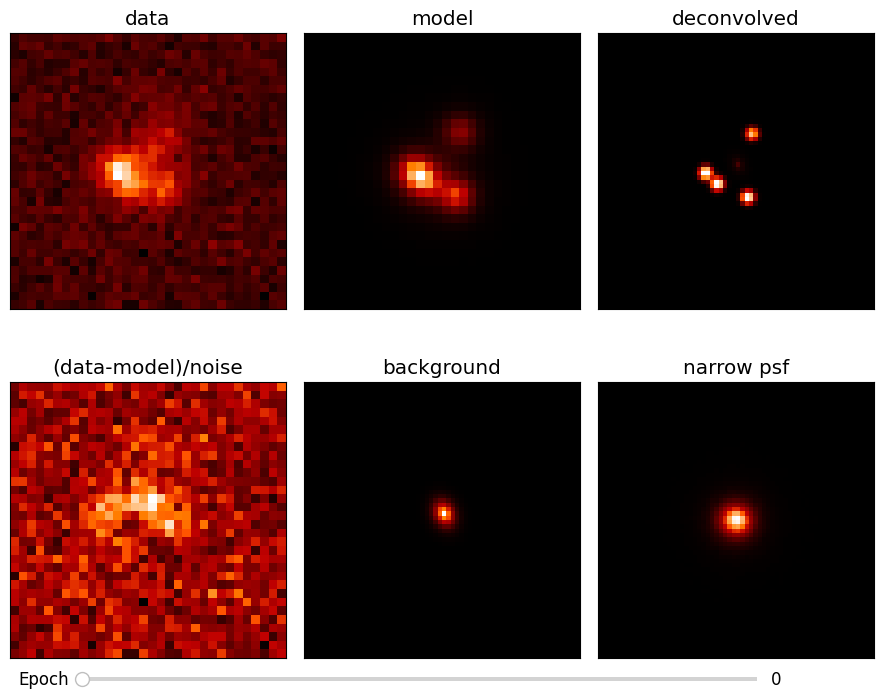

In [8]:
# utility function to view all epochs of our deconvolution.
# use the slider for this.
view_deconv_model(model, kwargs_init, data, sigma_2)

## Preparing the fitting routine

First, we will just fit an analytical Sersic profile for the background. 

Step 1, fixing : ['pts-source-astrometry', 'background']
Step 1/2 took 20 seconds
Kwargs partial at step 1/2 {'kwargs_analytic': {'a': Array([8.644581 , 6.066978 , 5.898624 , 2.4691775, 9.23244  , 6.33383  ,
       7.5872393, 3.1142821, 8.403825 , 6.4150486, 8.247307 , 2.7338974,
       8.528353 , 6.5486593, 7.7643194, 1.8617381], dtype=float32), 'c_x': Array([-3.22, -1.88,  1.63,  2.1 ], dtype=float32), 'c_y': Array([ 0.03, -1.23, -2.77,  4.6 ], dtype=float32), 'dx': Array([-0.38311383, -1.466129  , -0.62153786, -0.36803028], dtype=float32), 'dy': Array([ 0.25862256, -0.59510833,  0.5137097 ,  0.27786317], dtype=float32), 'alpha': Array([0., 0., 0., 0.], dtype=float32)}, 'kwargs_background': {'mean': Array([0., 0., 0., 0.], dtype=float32), 'h': Array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)}, 'kwargs_sersic': {'amp': Array([5.543559], dtype=float32), 'R_sersic': Array([3.8872135], dtype=float32), 'n_sersic': Array([0.60405165], dtype=float32), 'center_x': Array([0.770618], dtype=

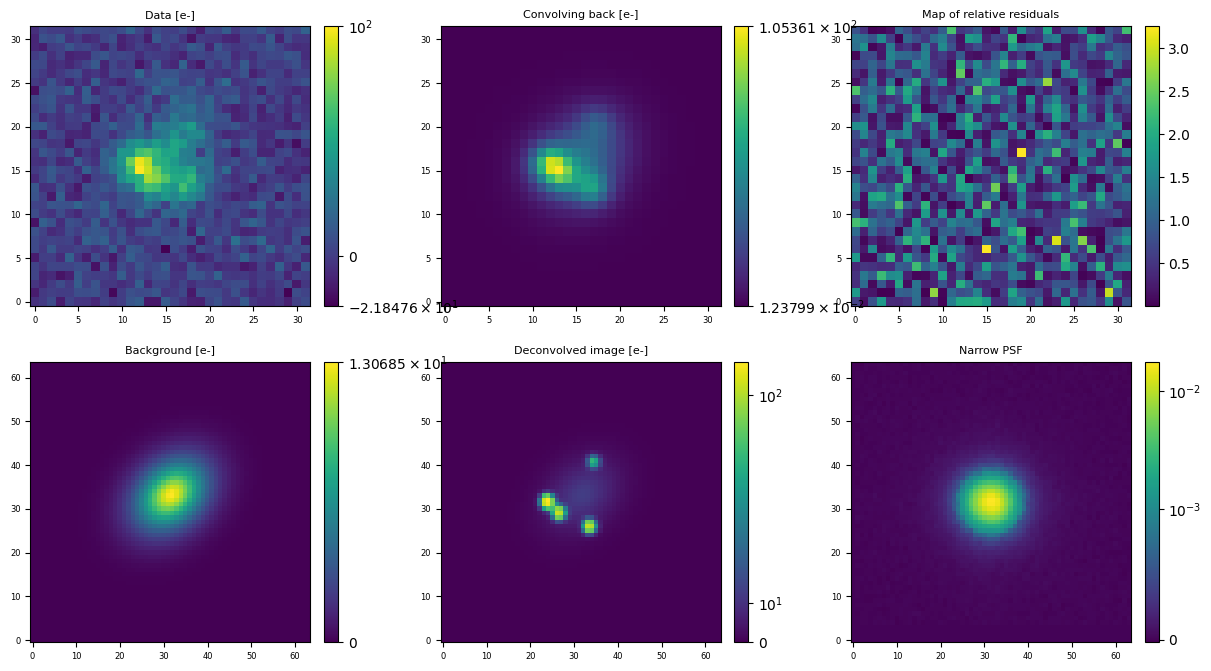

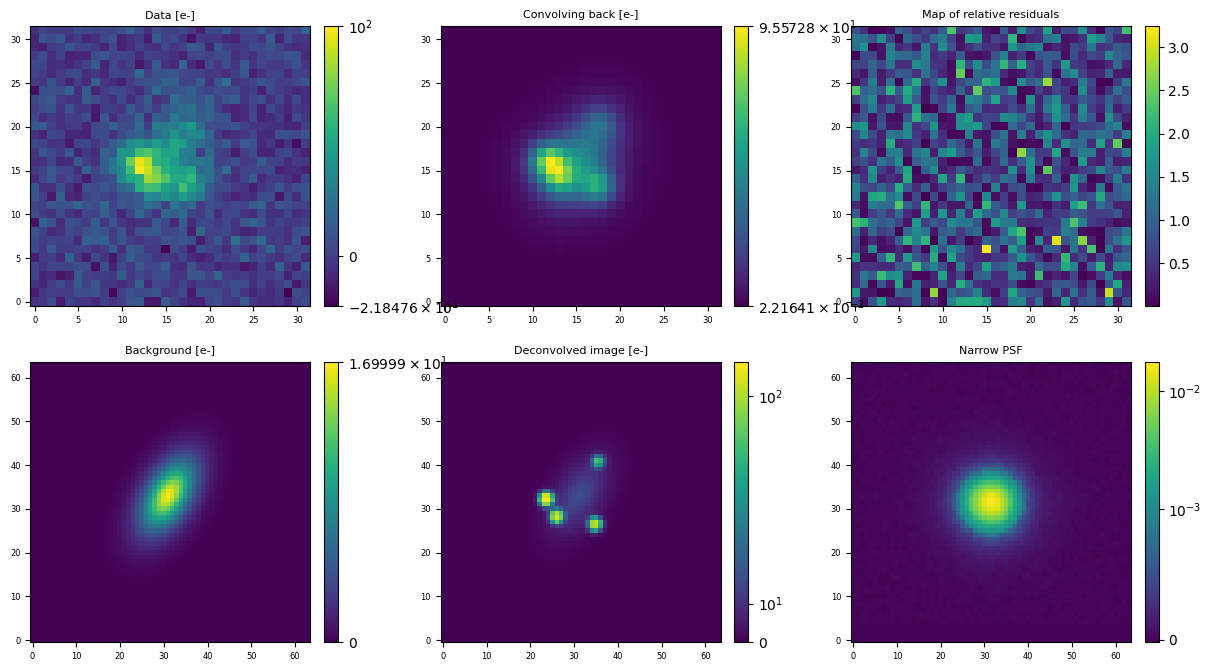

In [9]:
#Selecting the fixed components at each step, the rest is free. Format [['pts-source-astrometry','pts-source-photometry','background'],['pts-source-astrometry','pts-source-photometry'], ...]
fitting_sequence = [
                    ['pts-source-astrometry', 'background'], #step 1 : fix the astrometry and the pixelated background. Optimise the Sersic profile + photometry of the point sources
                    ['background'], #step 2: release astrometry, keep the pixelated background constant.
        ]
    
#Since we have no regularisation, we can use 'l-bfgs-b'. 
optim_list = ['l-bfgs-b','l-bfgs-b']

#l-fgs-b, you can use the following parameters: 
kwargs_lbfgs = {'maxiter':50}

#list of configuration for the optimsers 
kwargs_optim_list = [kwargs_lbfgs, kwargs_lbfgs] 

#we apply our astrometric prior nonly when the point sources are free (i.e. not for the second step)
prior_list=[None,None]

model, parameters, loss, kwargs_partial_list, fig_list, LogL_list, loss_history_list = multi_steps_deconvolution(data, model, parameters, sigma_2, s, subsampling_factor,
                                                                                    fitting_sequence = fitting_sequence,
                                                                                    optim_list = optim_list, kwargs_optim_list = kwargs_optim_list,
                                                                                    lambda_scales = 0, lambda_hf =0, 
                                                                                    lambda_positivity_ps=100, #we don't want the poitn source to be negative
                                                                                    prior_list = prior_list,
                                                                                    adjust_sky = False, #Sky has already been subtracted
                                                                                    noise_propagation = 'MC')

{'kwargs_analytic': {'a': Array([8.943409 , 6.1028123, 6.4271116, 2.5924249, 9.53192  , 7.0340986,
       7.866683 , 3.0302744, 8.966034 , 7.019171 , 8.728069 , 3.1708317,
       8.986778 , 7.2202425, 8.092712 , 2.336233 ], dtype=float32),
                     'alpha': Array([0., 0., 0., 0.], dtype=float32),
                     'c_x': Array([-3.340893 , -2.1147642,  2.263727 ,  2.6192284], dtype=float32),
                     'c_y': Array([ 0.24793988, -1.7338728 , -2.6060057 ,  4.5273404 ], dtype=float32),
                     'dx': Array([-0.39504325, -1.452182  , -0.620922  , -0.37833127], dtype=float32),
                     'dy': Array([ 0.3462075 , -0.50125337,  0.5869011 ,  0.32591274], dtype=float32)},
 'kwargs_background': {'h': Array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
                       'mean': Array([0., 0., 0., 0.], dtype=float32)},
 'kwargs_sersic': {'R_sersic': Array([3.8040087], dtype=float32),
                   'amp': Array([7.2454295], dtype=float32),

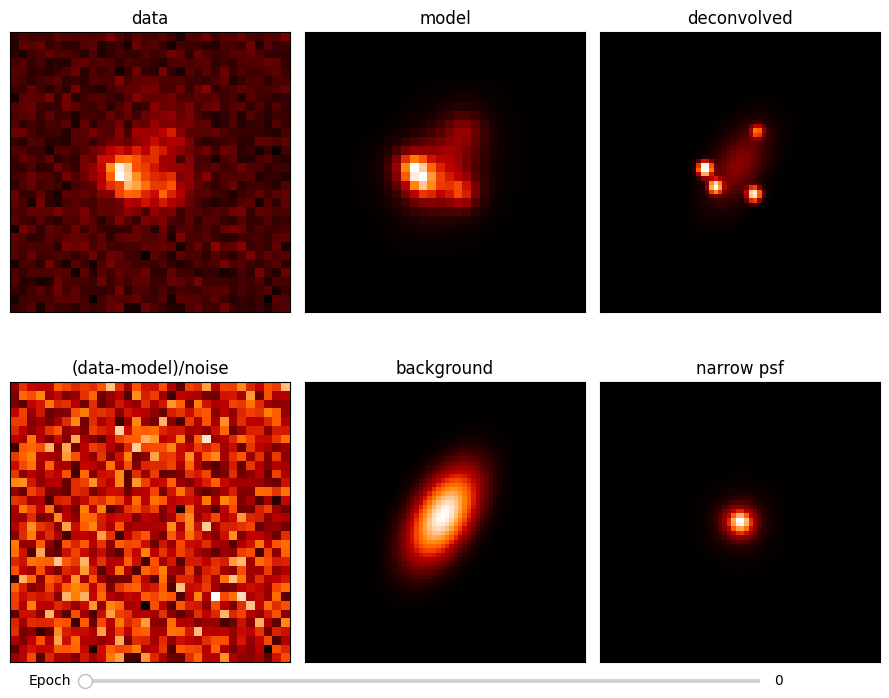

In [10]:
# Printing and visualizing the partial results
kwargs_partial = deepcopy(parameters.best_fit_values(as_kwargs=True))
pprint(kwargs_partial)
view_deconv_model(model, kwargs_partial, data, sigma_2)

# Fitting pixelated correction.

This model is pretty good but we are going to add a pixelated correction to the background. We will fix the Sersic profile and adjust the regularised pixelated grid 

Step 1, fixing : ['sersic', 'pts-source-astrometry']


optax.adabelief: 100%|██████████| 500/500 [00:33<00:00, 14.82it/s]


Step 1/2 took 34 seconds
Kwargs partial at step 1/2 {'kwargs_analytic': {'a': Array([8.6979475, 7.45107  , 6.1515646, 2.8894153, 9.029747 , 8.689243 ,
       7.785295 , 3.4488437, 8.823427 , 8.351574 , 8.392129 , 3.5005653,
       8.4652   , 8.80681  , 7.804341 , 2.6069877], dtype=float32), 'c_x': Array([-3.340893 , -2.1147642,  2.263727 ,  2.6192284], dtype=float32), 'c_y': Array([ 0.24793988, -1.7338728 , -2.6060057 ,  4.5273404 ], dtype=float32), 'dx': Array([-0.41093487, -1.4942367 , -0.60521996, -0.38976687], dtype=float32), 'dy': Array([ 0.48613223, -0.34581956,  0.6895802 ,  0.47694352], dtype=float32), 'alpha': Array([0., 0., 0., 0.], dtype=float32)}, 'kwargs_background': {'mean': Array([0., 0., 0., 0.], dtype=float32), 'h': Array([0.33500466, 0.3274441 , 0.14000854, ..., 0.2981133 , 0.30347583,
       0.30115396], dtype=float32)}, 'kwargs_sersic': {'amp': Array([7.2454295], dtype=float32), 'R_sersic': Array([3.8040087], dtype=float32), 'n_sersic': Array([0.6022273], dtype=floa

optax.adabelief: 100%|██████████| 500/500 [00:33<00:00, 15.14it/s]


Step 2/2 took 33 seconds
Kwargs partial at step 2/2 {'kwargs_analytic': {'a': Array([7.740803 , 8.347933 , 6.201072 , 2.917489 , 7.887897 , 9.618404 ,
       7.7726097, 3.4539156, 7.8783712, 9.199841 , 8.293959 , 3.544837 ,
       7.303427 , 9.89167  , 7.8788114, 2.6283336], dtype=float32), 'c_x': Array([-3.4009187, -2.301268 ,  2.187679 ,  2.5912626], dtype=float32), 'c_y': Array([ 0.5654382, -1.22468  , -2.4742167,  4.6880507], dtype=float32), 'dx': Array([-0.42284828, -1.4983376 , -0.5952827 , -0.3940693 ], dtype=float32), 'dy': Array([ 0.34242788, -0.49942696,  0.5008859 ,  0.31884953], dtype=float32), 'alpha': Array([0., 0., 0., 0.], dtype=float32)}, 'kwargs_background': {'mean': Array([0., 0., 0., 0.], dtype=float32), 'h': Array([0.07652059, 0.07344237, 0.03802616, ..., 0.08418214, 0.08587411,
       0.04068779], dtype=float32)}, 'kwargs_sersic': {'amp': Array([7.2454295], dtype=float32), 'R_sersic': Array([3.8040087], dtype=float32), 'n_sersic': Array([0.6022273], dtype=float32)

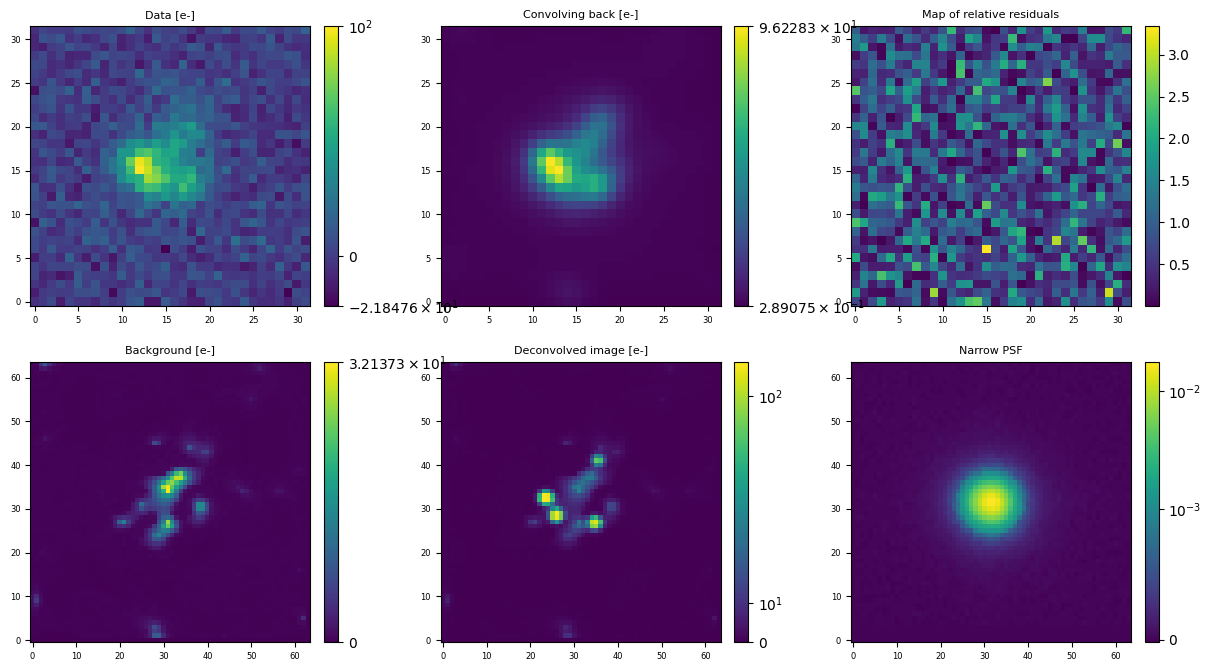

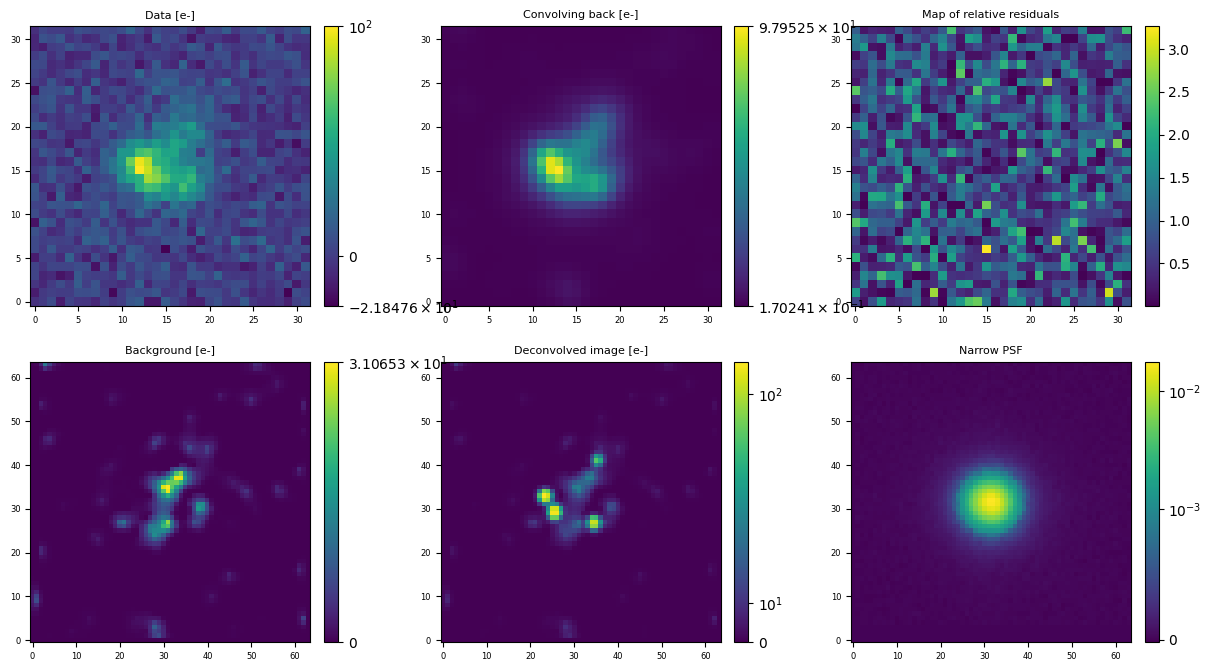

In [11]:
#Selecting the fixed components at each step, the rest is free. Format [['pts-source-astrometry','pts-source-photometry','background'],['pts-source-astrometry','pts-source-photometry'], ...]
fitting_sequence = [
                    ['sersic', 'pts-source-astrometry'], #step 1 : fix the Sersic profile and the astrometry, release the background
                    ['sersic'],
        ]
    
optim_list = ['adabelief','adabelief']
kwargs_optax1 = {'max_iterations': 500, 'min_iterations': None,
        'init_learning_rate': 5e-2, 'schedule_learning_rate': True,
        'restart_from_init': False, 'stop_at_loss_increase': False,
        'progress_bar': True, 'return_param_history': True
    }
kwargs_optax2 = {
        'max_iterations': 500, 'min_iterations': None,
        'init_learning_rate': 1e-2, 'schedule_learning_rate': True,
        'restart_from_init': False, 'stop_at_loss_increase': False,
        'progress_bar': True, 'return_param_history': True
    }
kwargs_optim_list = [kwargs_optax1, kwargs_optax2] 
prior_list=[None,None]

parameters = ParametersDeconv(kwargs_partial, 
                              kwargs_fixed, 
                              kwargs_up=kwargs_up, 
                              kwargs_down=kwargs_down)

model, parameters, loss, kwargs_partial_list, fig_list, LogL_list, loss_history_list = multi_steps_deconvolution(data, model, parameters, sigma_2, s, subsampling_factor,
                                                                                    fitting_sequence = fitting_sequence,
                                                                                    optim_list = optim_list, kwargs_optim_list = kwargs_optim_list,
                                                                                    lambda_scales = lambda_scales, lambda_hf =lambda_hf, 
                                                                                    lambda_positivity_ps=100, #we don't want the poitn source to be negative
                                                                                    prior_list = prior_list,
                                                                                    adjust_sky = False, #Sky has already been subtracted
                                                                                    noise_propagation = 'MC')

Step 1, optimiser adabelief
Step 2, optimiser adabelief
{'kwargs_analytic': {'a': Array([7.740803 , 8.347933 , 6.201072 , 2.917489 , 7.887897 , 9.618404 ,
       7.7726097, 3.4539156, 7.8783712, 9.199841 , 8.293959 , 3.544837 ,
       7.303427 , 9.89167  , 7.8788114, 2.6283336], dtype=float32), 'c_x': Array([-3.4009187, -2.301268 ,  2.187679 ,  2.5912626], dtype=float32), 'c_y': Array([ 0.5654382, -1.22468  , -2.4742167,  4.6880507], dtype=float32), 'dx': Array([-0.42284828, -1.4983376 , -0.5952827 , -0.3940693 ], dtype=float32), 'dy': Array([ 0.34242788, -0.49942696,  0.5008859 ,  0.31884953], dtype=float32), 'alpha': Array([0., 0., 0., 0.], dtype=float32)}, 'kwargs_background': {'mean': Array([0., 0., 0., 0.], dtype=float32), 'h': Array([0.07652059, 0.07344237, 0.03802616, ..., 0.08418214, 0.08587411,
       0.04068779], dtype=float32)}, 'kwargs_sersic': {'amp': Array([7.2454295], dtype=float32), 'R_sersic': Array([3.8040087], dtype=float32), 'n_sersic': Array([0.6022273], dtype=floa

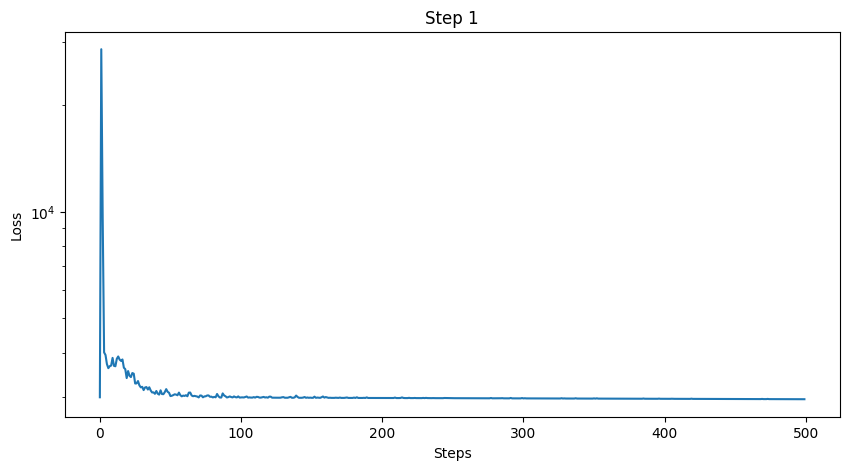

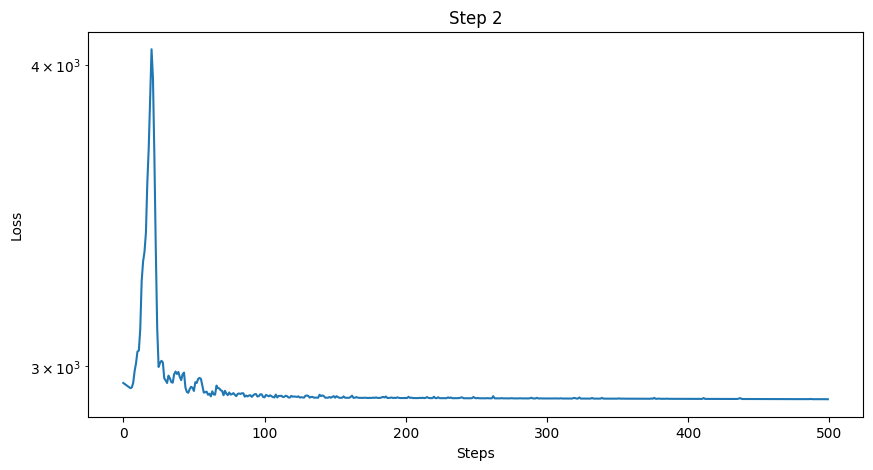

In [12]:
for i in range(len(loss_history_list)):
    print('Step %i, optimiser %s'%(i+1, optim_list[i]))
    plot_loss(loss_history=loss_history_list[i], title = 'Step %i'%(i+1))

kwargs_final = deepcopy(parameters.best_fit_values(as_kwargs=True))
print(kwargs_final)
print('Overall Reduced Chi2 : ', loss.reduced_chi2(kwargs_final))

Now we will make a more customized plot, so we can show how to retrieve the different elements of the deconvolution from the model.

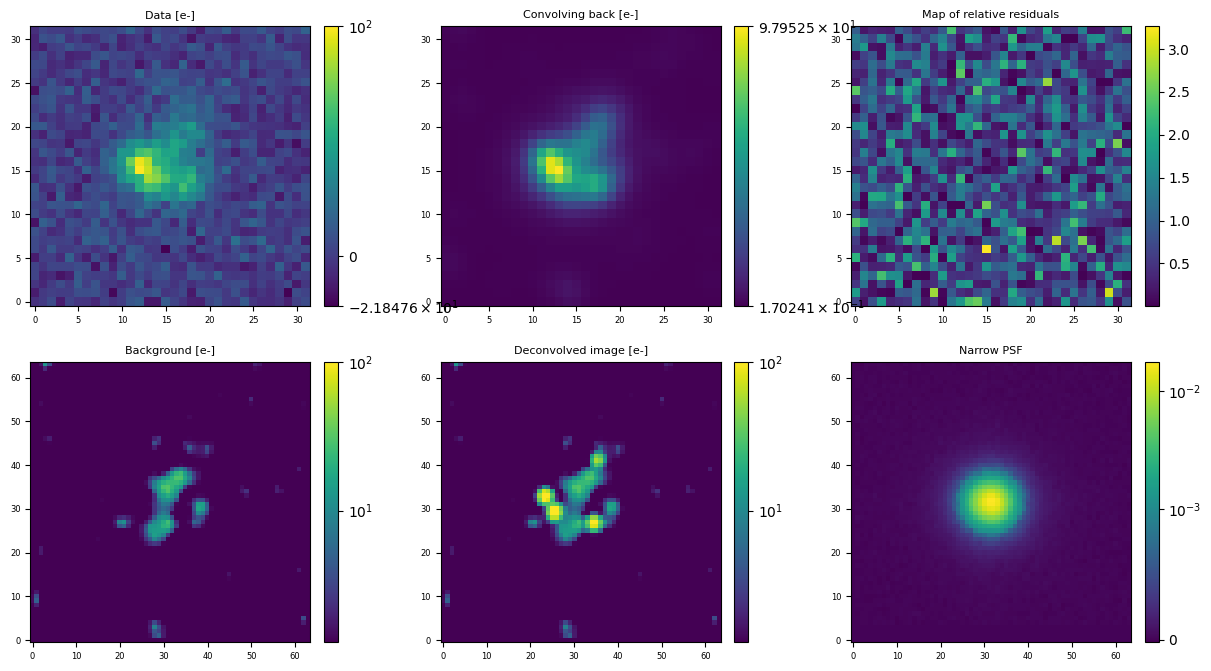

In [13]:
# Retrieving different elements of the deconvolved image
epoch = 0
output = model.model(kwargs_final)[epoch] 
deconv, h = model.getDeconvolved(kwargs_final, epoch)

cut_dict = {
            'linthresh':[100,100,None,10,10,1e-3],
            'vmin':[None,None, None, 2, 2, None],
            'vmax':[None, None, None, 100,100, None],
        }
#cut of the panels, given from left to right and from top to bottom
fig2 = plot_deconvolution(model, data, sigma_2, s, kwargs_final, epoch = epoch, units='e-', cut_dict = cut_dict)


In [14]:
output_folder = Path('./output/DELV_test')

# Uncomment the following line to save the obtained deconvolved image
output_folder.mkdir(parents=1, exist_ok=1)
model.export(output_folder, kwargs_final, data, sigma_2, epoch=None, format='fits') #save the product in fits files


Exporting all epochs


In [15]:
# getting the positions of the point sources in arcsecond:
pixsize = 0.238
print(kwargs_final['kwargs_analytic']['c_x'] * (pixsize/subsampling_factor))
print(kwargs_final['kwargs_analytic']['c_y'] * (pixsize/subsampling_factor))

[-0.40470934 -0.27385092  0.2603338   0.30836025]
[ 0.06728715 -0.14573692 -0.2944318   0.5578781 ]


In [16]:
print(f"Notebook runtime: {time()-t0:.01f} seconds.")

Notebook runtime: 151.1 seconds.
